In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pymc as pm

In [34]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [6]:
df.isnull().sum()


Date     0
Price    0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date')

# Preprocess the data
df['Price'] = df['Price'].interpolate()

C:\Users\hp\AppData\Local\Temp\ipykernel_19308\2268312663.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


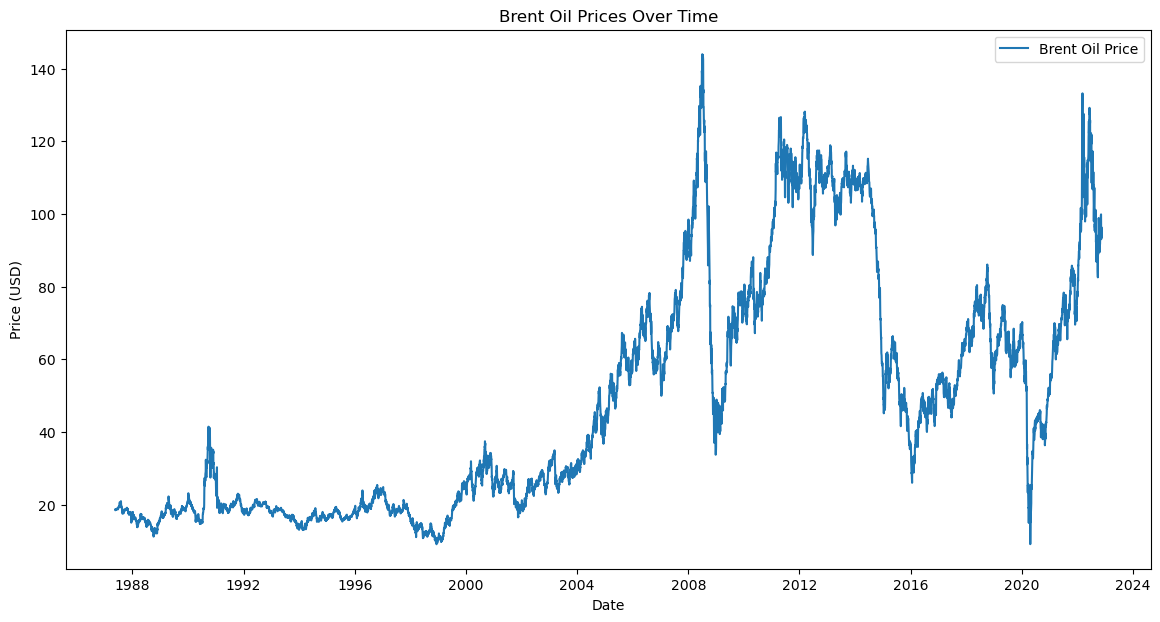

In [10]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time')
plt.legend()
plt.show()

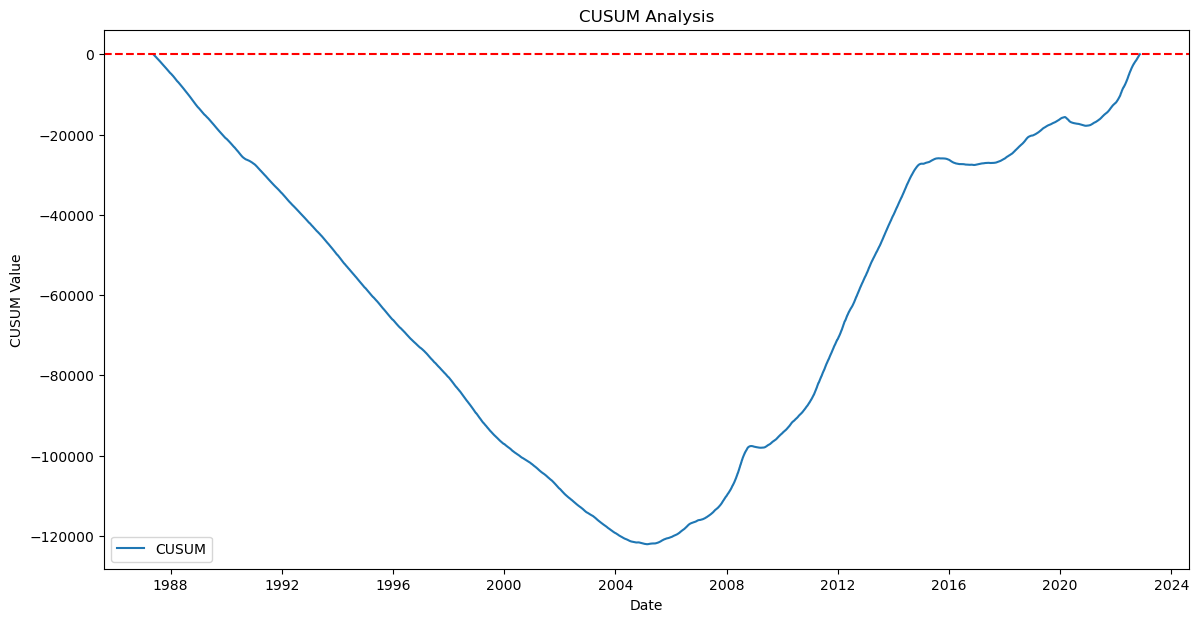

In [8]:

# CUSUM method
mean_price = df['Price'].mean()
cusum = np.cumsum(df['Price'] - mean_price)
plt.figure(figsize=(14, 7))
plt.plot(df.index, cusum, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Analysis')
plt.legend()
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mean_prior]
>Metropolis: [change_point]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2971 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


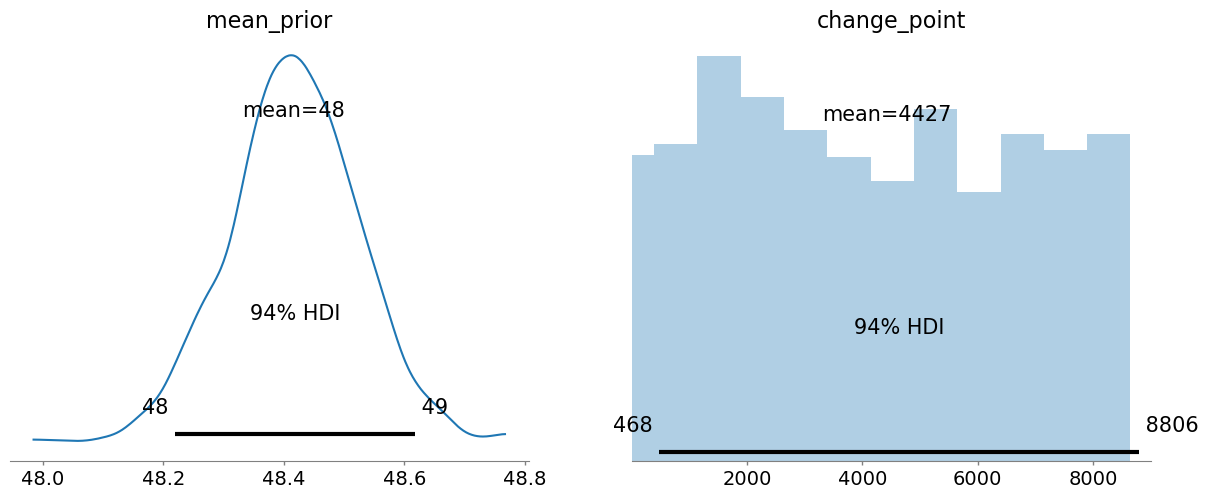

In [ ]:

# Bayesian Change Point Detection using PyMC
with pm.Model() as model:
    # Priors
    mean_prior = pm.Normal('mean_prior', mu=mean_price, sigma=10)
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(df)-1)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mean_prior, sigma=10, observed=df['Price'])

    # Inference
    trace = pm.sample(1000, tune=1000, cores=2)

# Plot results
pm.plot_posterior(trace)
plt.show()

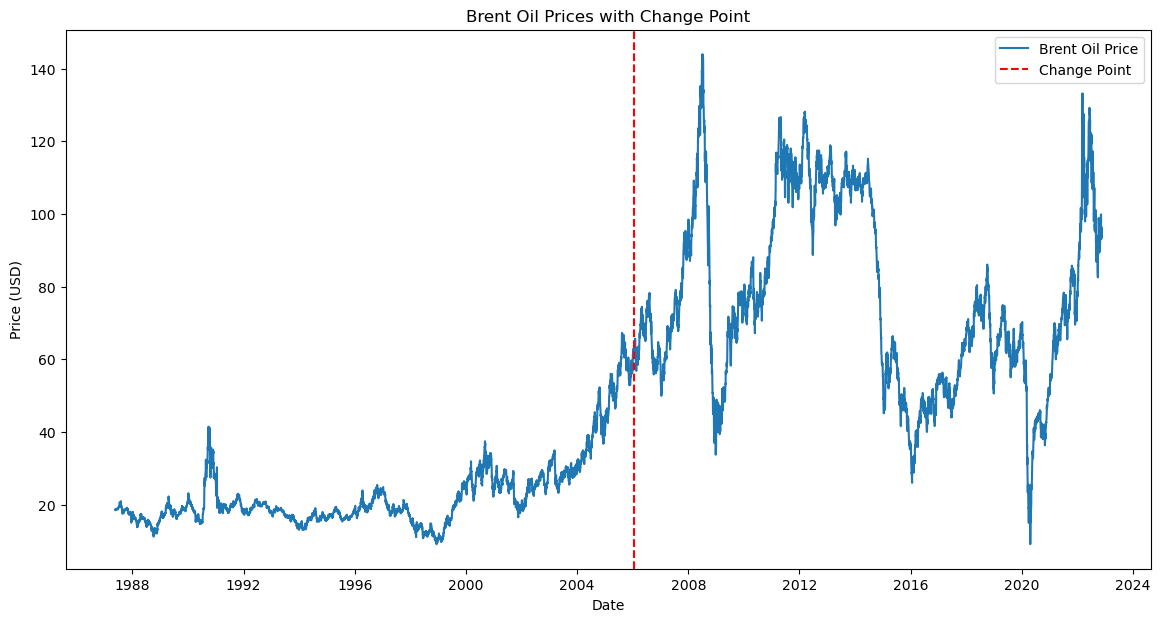

In [10]:
change_point_index = 4753

# Plot the data with the change point
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.axvline(x=df.index[change_point_index], color='red', linestyle='--', label='Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Change Point')
plt.legend()
plt.show()

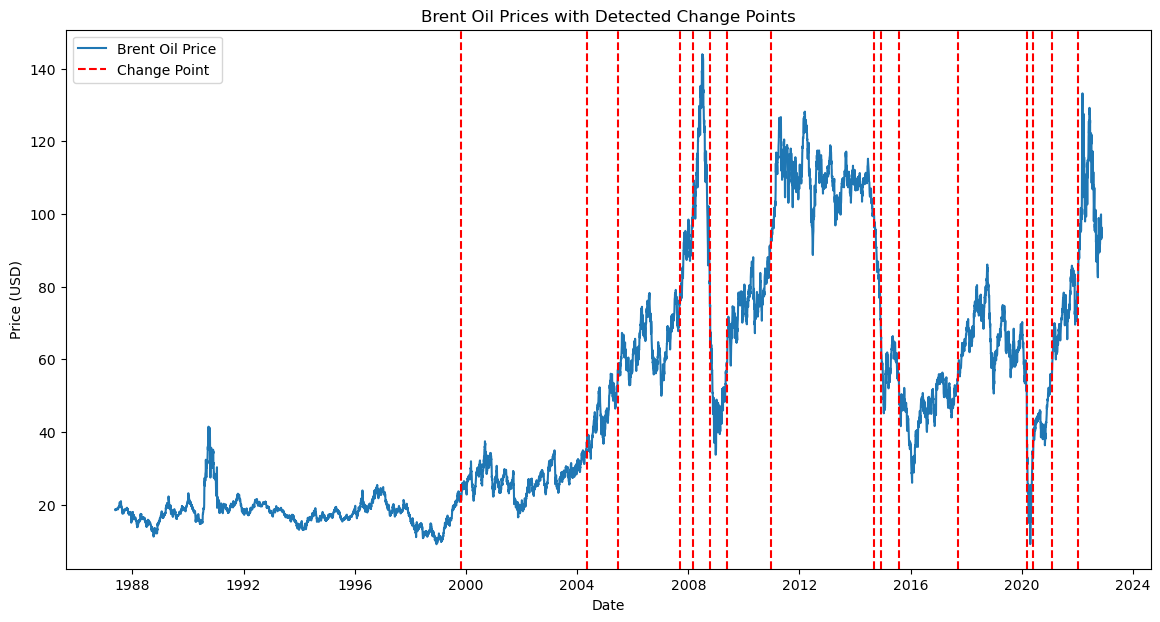

In [11]:
price_array = df['Price'].values
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_array)
change_points = algo.predict(pen=20)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.show()

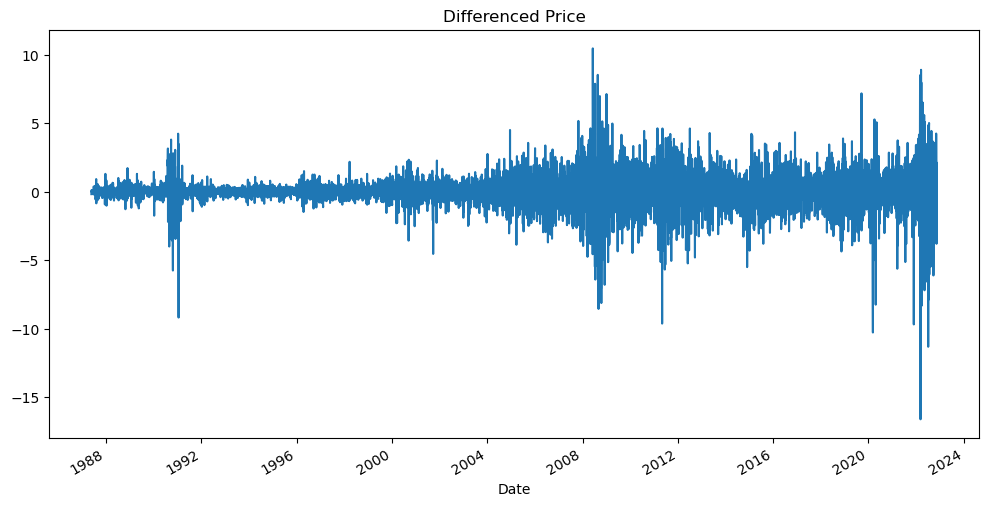

In [15]:
df['Price_diff'] = df['Price'] - df['Price'].shift(1)
df['Price_diff'].dropna().plot(figsize=(12, 6))
plt.title('Differenced Price')
plt.show()


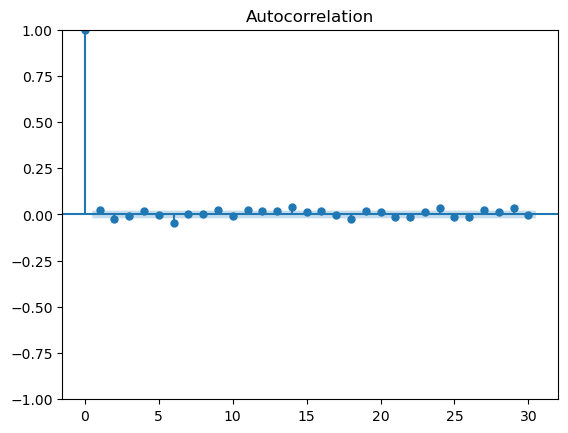

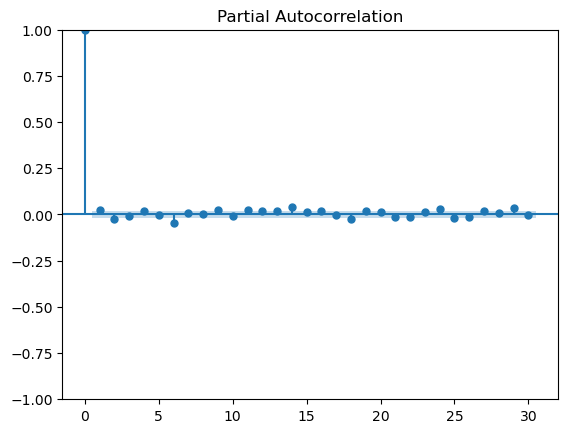

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Price_diff'].dropna(), lags=30)
plt.show()

plot_pacf(df['Price_diff'].dropna(), lags=30)
plt.show()


In [ ]:
##model tranning with Arima 
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()


c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


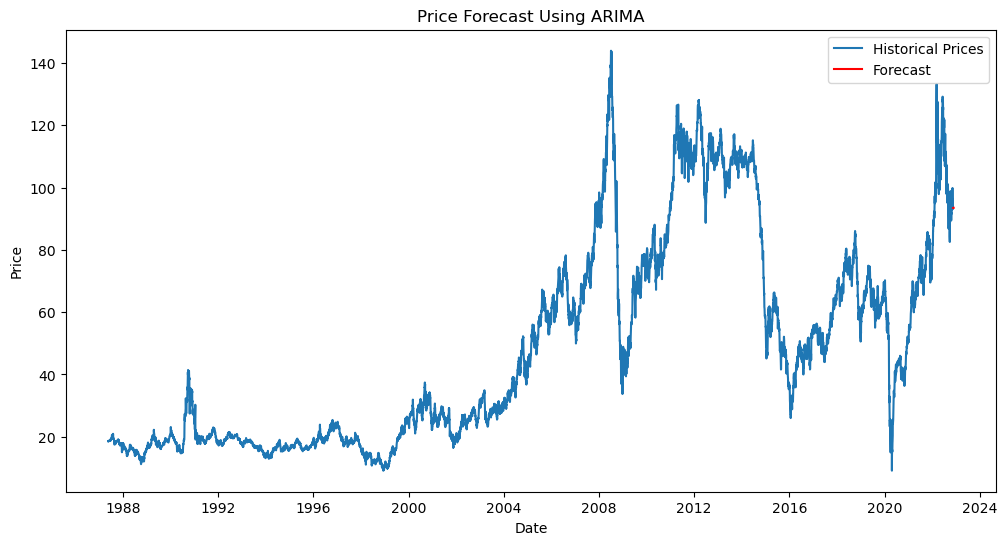

In [20]:
# Forecasting the next 10 time periods
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Prices')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Price Forecast Using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


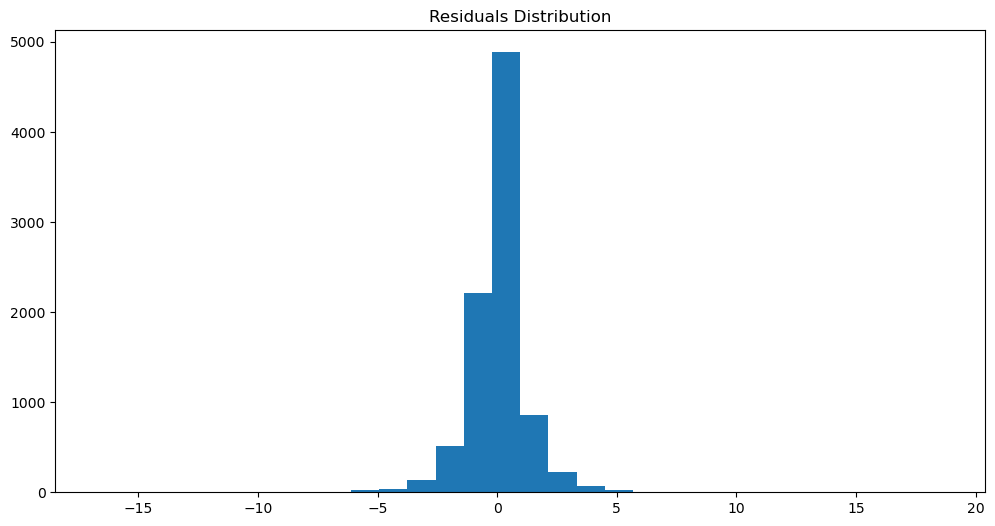

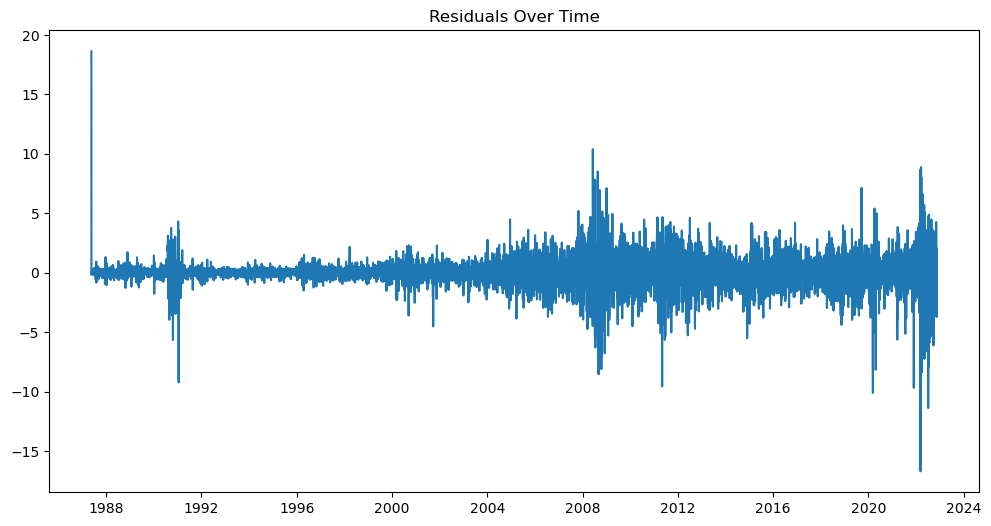

In [21]:
##Model evaluating

residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.show()

# Also, plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.show()



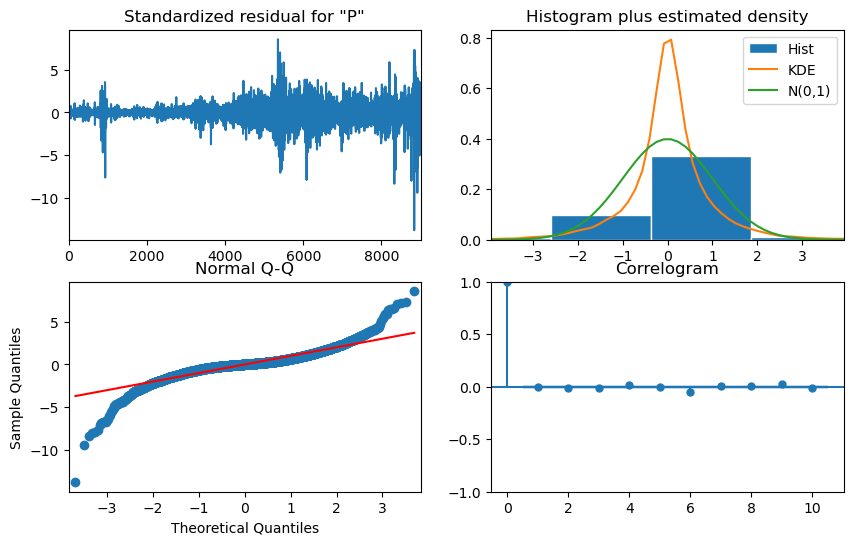

In [ ]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.show()

In [3]:
# Compute log returns for stationarity
df["Returns"] = np.log(df["Price"]).diff().dropna()
df = df.dropna()

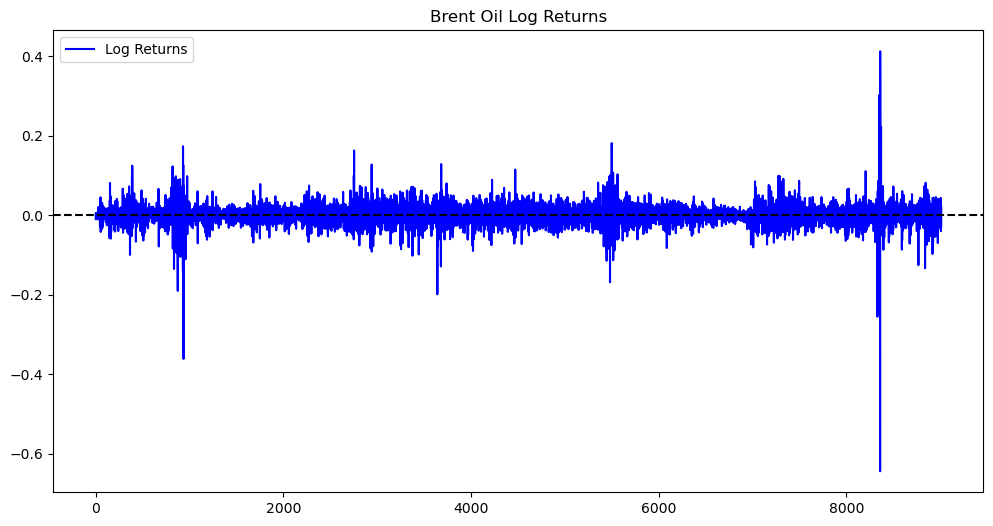

In [4]:
##Model Traning with GARCH Model
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Returns"], label="Log Returns", color="blue")
plt.axhline(0, linestyle="--", color="black")
plt.title("Brent Oil Log Returns")
plt.legend()
plt.show()

In [5]:
# Define and fit the GARCH model
from arch import arch_model
garch_model = arch_model(df["Returns"], vol="Garch", p=1, q=1, mean="Zero", dist="normal")
garch_fit = garch_model.fit(disp="off")

# Print the summary
print(garch_fit.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                22182.9
Distribution:                  Normal   AIC:                          -44359.8
Method:            Maximum Likelihood   BIC:                          -44338.5
                                        No. Observations:                 9010
Date:                Sat, Feb 22 2025   Df Residuals:                     9010
Time:                        10:40:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3037e-05  2.280e-12  5.719e+06      0.000 [1.

c:\Users\hp\anaconda\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006518. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


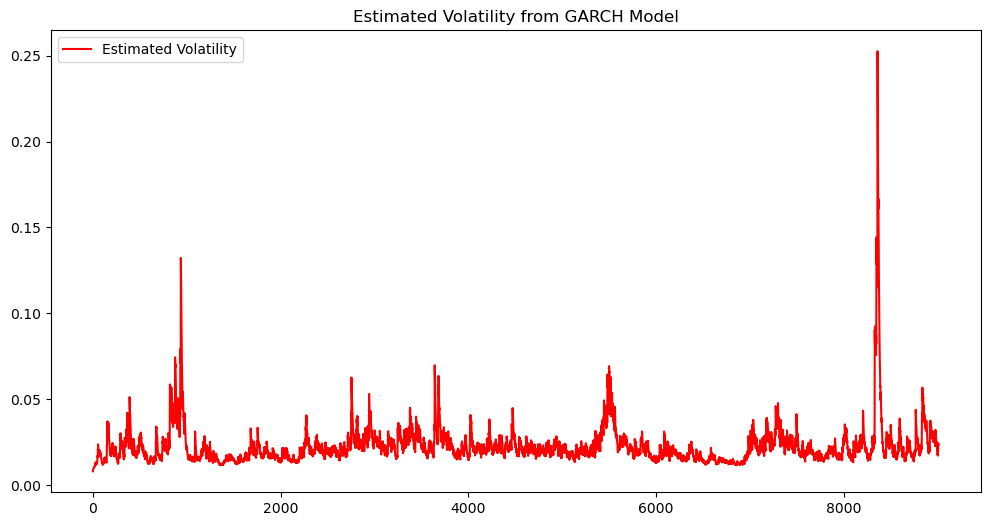

In [6]:
## Plot Volatility Estimates
df["Volatility"] = garch_fit.conditional_volatility

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Volatility"], label="Estimated Volatility", color="red")
plt.title("Estimated Volatility from GARCH Model")
plt.legend()
plt.show()


Random Forest MAE: 0.7729865224625645
Random Forest RMSE: 1.2429879579507808
Random Forest R²: 0.998595601826096


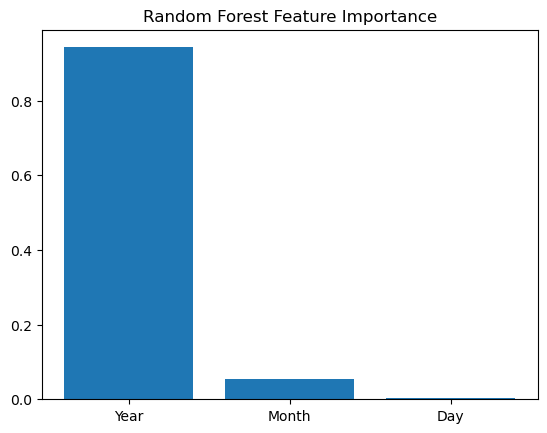

In [ ]:
##Model tranning and Evaluation for RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Features and Target
X = df[['Year', 'Month', 'Day']]  # Use more features if necessary
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
rf_pred = rf_model.predict(X_test)

# MAE (Mean Absolute Error)
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f'Random Forest MAE: {rf_mae}')

# RMSE (Root Mean Squared Error)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f'Random Forest RMSE: {rf_rmse}')

# R-squared (R²)
rf_r2 = r2_score(y_test, rf_pred)
print(f'Random Forest R²: {rf_r2}')

# Plotting feature importances (for Random Forest)
plt.bar(X.columns, rf_model.feature_importances_)
plt.title('Random Forest Feature Importance')
plt.show()

XGBoost MAE: 1.1408178149205872
XGBoost RMSE: 1.6673821487655982
XGBoost R²: 0.9974728750891437


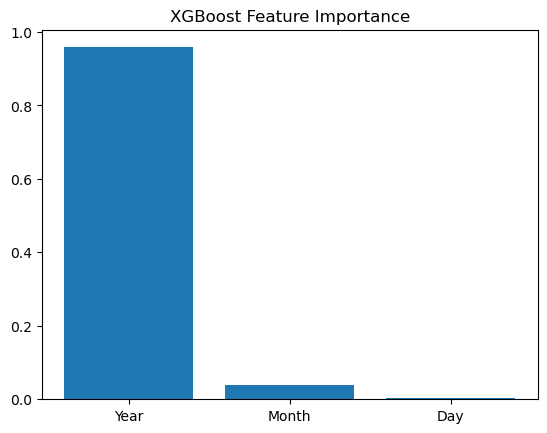

In [ ]:
##Model tranning and Evaluation for XGBregressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

## XGBoost Model (if you want to add it as well)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation for XGBoost
xgb_pred = xgb_model.predict(X_test)

# MAE (Mean Absolute Error) for XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f'XGBoost MAE: {xgb_mae}')

# RMSE (Root Mean Squared Error) for XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

# R-squared (R²) for XGBoost
xgb_r2 = r2_score(y_test, xgb_pred)
print(f'XGBoost R²: {xgb_r2}')

# Plotting feature importances for XGBoost
plt.bar(X.columns, xgb_model.feature_importances_)
plt.title('XGBoost Feature Importance')
plt.show()


In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Example: Assuming 'Date' column exists in df and 'Price' is the target
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Price']])

# Create data in the form of X (features) and y (target) for LSTM
def create_dataset(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Use past 30 days to predict the next day's price
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be compatible with LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))  # Predict the price

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# Rescale y_test back to original values
y_test_rescaled = scaler.inverse_transform([y_test])

# Evaluate the model
lstm_pred = np.squeeze(lstm_pred)

# MAE (Mean Absolute Error)
lstm_mae = np.mean(np.abs(lstm_pred - y_test_rescaled[0]))
print(f'LSTM MAE: {lstm_mae}')

# RMSE (Root Mean Squared Error)
lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled[0], lstm_pred))
print(f'LSTM RMSE: {lstm_rmse}')

# R-squared (R²)
lstm_r2 = r2_score(y_test_rescaled[0], lstm_pred)
print(f'LSTM R²: {lstm_r2}')


Epoch 1/10


c:\Users\hp\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0113
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 4.5061e-04
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.6444e-04
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.2249e-04
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.9357e-04
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.5273e-04
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.5190e-04
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.1592e-04
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2.1864e-04
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.0469e-04
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM MAE: 1.0625410686356984
LSTM RMSE: 1.6171435136500776
LSTM R²: 0.9976684543567097
